# Audio Length Analysis – Peru Cleaned Transcripts

This notebook **measures the duration of every MP3 audio clip** already generated for the Peru video-observation study, writes those lengths back into the data set, produces visualizations, and exports a length-filtered data frame.

### Objectives
1. **Compute** the true duration (in seconds & minutes) of each *First* and *Last* audio clip.
2. **Write** the results to new columns: `First Audio Length (sec)` / `(min)` and `Last Audio Length (sec)` / `(min)`.
3. **De-duplicate** lengths for rows that share the same 6- or 7-digit **School Clip identifier prefix**.
4. **Visualize** the distribution with histograms & summary stats.
5. **Create** a second data frame containing only rows where **either audio ≥ 15 minutes** ( ≥ 900 sec ) and save it to CSV.

> **Run-time note** All file operations are streamed; durations are read with *pydub* (FFmpeg-powered) so no decoding is written to disk.


## 0 – Environment & Dependencies
*Installs are silent in Colab; skip if already satisfied locally.*

In [1]:
# Install pydub & tqdm if not present
!pip -q install pydub tqdm mutagen ffmpeg-python

import importlib.util, os, sys, subprocess, json, re, time, math, textwrap, hashlib, random, string
from pathlib import Path
import pandas as pd
from tqdm.notebook import tqdm
from pydub import AudioSegment
import matplotlib.pyplot as plt

# Detect Colab for Drive mount convenience
IN_COLAB = importlib.util.find_spec("google.colab") is not None
if IN_COLAB:
    from google.colab import drive as _gdrive
    _gdrive.mount('/content/drive')
    DISPLAY_BASE = Path('/content/drive/My Drive')
else:
    DISPLAY_BASE = Path('/')  # root placeholder for Path.relative_to later

/opt/anaconda3/envs/Harvard/lib/python3.12/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


## 1 – Path Configuration & Data Load

In [2]:
# ---------- USER-EDITABLE PATHS ----------

# Primary cleaned transcript CSV (with audio clip columns already present)
LOCAL_CSV_PATH = Path('/Users/mkrasnow/Desktop/montesa/new/formattedData/TIMESTAMPED_peru_cleaned_transcripts.csv')

# In Colab, map the above path inside Drive; adjust if your Drive structure differs
if IN_COLAB:
    CSV_PATH = Path('/content/drive/My Drive/montesa/new/formattedData/TIMESTAMPED_peru_cleaned_transcripts.csv')
else:
    CSV_PATH = LOCAL_CSV_PATH

assert CSV_PATH.exists(), f"❌ CSV file not found at {CSV_PATH} – check the path."
print(f"✅ Loading transcripts from: {CSV_PATH}")

df = pd.read_csv(CSV_PATH)
print(f"Rows: {len(df):,} | Columns: {len(df.columns)}")

✅ Loading transcripts from: /Users/mkrasnow/Desktop/montesa/new/formattedData/TIMESTAMPED_peru_cleaned_transcripts.csv
Rows: 203 | Columns: 73


## 2 – Helper Functions

In [3]:
def full_audio_path(rel_path: str) -> Path:
    """Return absolute Path to an MP3 given a relative column entry."""
    if pd.isna(rel_path) or not str(rel_path).strip():
        return None
    if IN_COLAB:
        return Path('/content/drive/My Drive') / rel_path
    else:
        return Path(rel_path).expanduser().resolve()

def duration_seconds(path: Path) -> float:
    """Fast duration extraction using pydub/ffmpeg. Returns seconds (float)."""
    try:
        audio = AudioSegment.from_file(path)
        return audio.duration_seconds
    except Exception as e:
        print(f"⚠️ Failed reading {path}: {e}")
        return math.nan

def identifier_prefix(identifier, length: int = 7):
    """Return the first `length` numeric chars of School_Clip as grouping key."""
    if pd.isna(identifier):
        return None
    m = re.match(r"(\d{6,7})", str(identifier))
    return m.group(1) if m else str(identifier)

## 3 – Compute Durations

In [4]:
# Ensure new length columns exist
length_cols = [
    'First Audio Length (sec)', 'First Audio Length (min)',
    'Last Audio Length (sec)',  'Last Audio Length (min)'
]
for col in length_cols:
    if col not in df.columns:
        df[col] = math.nan

# Build a cache to avoid repeat decoding for same identifier prefix
length_cache = {}

iter_rows = tqdm(df.iterrows(), total=len(df), desc="Measuring audio", unit="row")
for idx, row in iter_rows:
    prefix = identifier_prefix(row.get('School_Clip', ''))
    if prefix in length_cache:
        first_len, last_len = length_cache[prefix]
    else:
        # FIRST AUDIO
        first_audio_path = full_audio_path(row.get('First Audio Clip'))
        first_len = duration_seconds(first_audio_path) if first_audio_path and first_audio_path.exists() else math.nan
        # LAST AUDIO
        last_audio_path  = full_audio_path(row.get('Last Audio Clip'))
        last_len  = duration_seconds(last_audio_path)  if last_audio_path  and last_audio_path.exists()  else math.nan
        # Cache it
        length_cache[prefix] = (first_len, last_len)

    # Write lengths (sec + min)
    if math.isfinite(first_len):
        df.at[idx, 'First Audio Length (sec)'] = first_len
        df.at[idx, 'First Audio Length (min)'] = first_len / 60
    if math.isfinite(last_len):
        df.at[idx, 'Last Audio Length (sec)'] = last_len
        df.at[idx, 'Last Audio Length (min)'] = last_len / 60

# Quick completeness report
valid_first = df['First Audio Length (sec)'].notna().sum()
valid_last  = df['Last Audio Length (sec)'].notna().sum()
print(f"🎯 Durations computed – First: {valid_first}/{len(df)}, Last: {valid_last}/{len(df)}")

Measuring audio:   0%|          | 0/203 [00:00<?, ?row/s]

🎯 Durations computed – First: 0/203, Last: 0/203


## 4 – Visualization

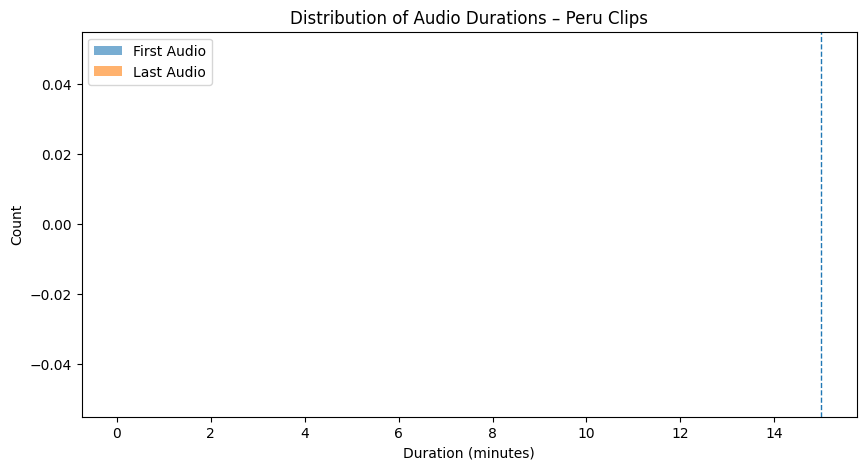

,count,mean,std,min,25%,50%,75%,max
First Audio Length (min),0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Last Audio Length (min),0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Histogram of first & last audio lengths (minutes)
plt.figure(figsize=(10,5))
plt.hist(df['First Audio Length (min)'].dropna(), bins=40, alpha=0.6, label='First Audio')
plt.hist(df['Last Audio Length (min)'].dropna(),  bins=40, alpha=0.6, label='Last Audio')
plt.axvline(15, linestyle='--', lw=1)
plt.xlabel('Duration (minutes)')
plt.ylabel('Count')
plt.title('Distribution of Audio Durations – Peru Clips')
plt.legend()
plt.show()

# Summary statistics
summary = df[[
    'First Audio Length (min)', 'Last Audio Length (min)'
]].describe(percentiles=[.25,.5,.75]).T
display(summary.round(2))

## 5 – Filter ≥ 15 Minute Recordings

In [6]:
MIN_THRESHOLD_SEC = 15 * 60  # 900

mask_15 = (
    (df['First Audio Length (sec)'] >= MIN_THRESHOLD_SEC) |
    (df['Last Audio Length (sec)']  >= MIN_THRESHOLD_SEC)
)
df_long = df[mask_15].copy()
print(f"Rows ≥ 15 min: {len(df_long)}/{len(df)} ({len(df_long)/len(df)*100:.1f}%)")

Rows ≥ 15 min: 0/203 (0.0%)


## 6 – Save Results

In [7]:
# Where to place outputs
if IN_COLAB:
    OUT_DIR = Path('/content/drive/My Drive/montesa/new/formattedData')
else:
    OUT_DIR = Path('/Users/mkrasnow/Desktop/montesa/new/formattedData')
OUT_DIR.mkdir(parents=True, exist_ok=True)

LEN_ENRICHED_CSV   = OUT_DIR / 'TIMESTAMPED_peru_cleaned_transcripts_with_lengths.csv'
LONG_ONLY_CSV      = OUT_DIR / 'TIMESTAMPED_peru_cleaned_transcripts_MIN15.csv'

# Save both
df.to_csv(LEN_ENRICHED_CSV, index=False)
df_long.to_csv(LONG_ONLY_CSV, index=False)

print(f"💾 Saved length-enriched data → {LEN_ENRICHED_CSV}")
print(f"💾 Saved ≥15 min subset  → {LONG_ONLY_CSV}")

💾 Saved length-enriched data → /Users/mkrasnow/Desktop/montesa/new/formattedData/TIMESTAMPED_peru_cleaned_transcripts_with_lengths.csv
💾 Saved ≥15 min subset  → /Users/mkrasnow/Desktop/montesa/new/formattedData/TIMESTAMPED_peru_cleaned_transcripts_MIN15.csv


## 7 – Wrap-Up

*Notebook complete.* Durations have been measured, visualized, and exported. You can now proceed with downstream transcription quality checks or further analysis on the ≥15-minute clips.